In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import sqlite3
import mysql.connector as cnt
import plotly.express as px

In [30]:
#prisijungimas prie mySQL, ir kursoriaus sukūrimas
DB = cnt.connect(
host = '88.223.121.130',
user='user',
password='slaptazodis',
port=3306,
database='works'
)
C=DB.cursor()

In [31]:
# Turite nusiskaityti iš SQL DB lentelės autopliuslt į Pandas DataFrame gamintoją, 
# kainą, pagaminimo datą, ridą, pavarų tipą, variklio informaciją. 
# SQL užklausoje turite atmesti tuos įrašus, kur rida nenurodyta, taip pat palikite 
# tik nesikartojančius įrašus (atranka pagal ID stuleplį - jei ID sutampa - reiškia, jog skelbimas dubliuojasi)
# pridėkite dar vieną stulpelį, kur būtų rida, suapvalinta 5000 km intervalais

sql="""select Gamintojas, pagaminimo_data as Data, cast(replace(price,' ','') as float) as Kaina, cast(replace(replace(rida,' ',''),'km','')as float) as Rida, pavaros as Pavaros, variklis as Variklis  from autopliuslt
where Rida <> 'Nenurodyta'
group by id;"""

# Destytojo
# #sql užklausa per pandas sql_query
# sql="""with T1
# as (select *, row_number() over (partition by id) as rc from autopliuslt)
# select gamintojas, rida, price as kaina,
# pagaminimo_data as data,
# pavaros, variklis
# from T1
# where rc = 1 and rida != 'Nenurodyta' order by gamintojas"""
# df = pd.read_sql_query(sql, con=DB)
# df.head(2)

df_ap = pd.read_sql_query(sql, con=DB)
def amz(s):
    return 2024-int(s[:4])
def rid(r):
    # return round(r/5000,0)*5000
    return np.ceil(r/5000)*5000
df_ap['R5000'] = df_ap['Rida'].apply(rid)
df_ap['Amžius'] = df_ap['Data'].apply(amz)
df_ap.head()

# Destytojo
# df['R'] = df['rida'].apply(lambda s: float(s.replace(' ','').replace('km','')))
# df['K'] = df['kaina'].apply(lambda s: float(s.replace(' ','').replace('km','')))
# df['amžius'] = df['data'].apply(lambda s: 2024-int(s[:4]))
# df.head()

,Gamintojas,Data,Kaina,Rida,Pavaros,Variklis,R5000,Amžius
0,Mitsubishi,1996,1450.0,173810.0,Mechaninė,2500 cm³,175000.0,28
1,Isuzu,2003,850.0,186684.0,Mechaninė,3000 cm³,190000.0,21
2,Hyundai,2004,1450.0,159326.0,Mechaninė,2400 cm³,160000.0,20
3,Toyota,2008,1450.0,249449.0,Mechaninė,2200 cm³,250000.0,16
4,Mercedes-Benz,2003,1450.0,205997.0,Automatinė,2700 cm³,210000.0,21


In [ ]:
# seaborn naudojamas trendams vizualizuoti

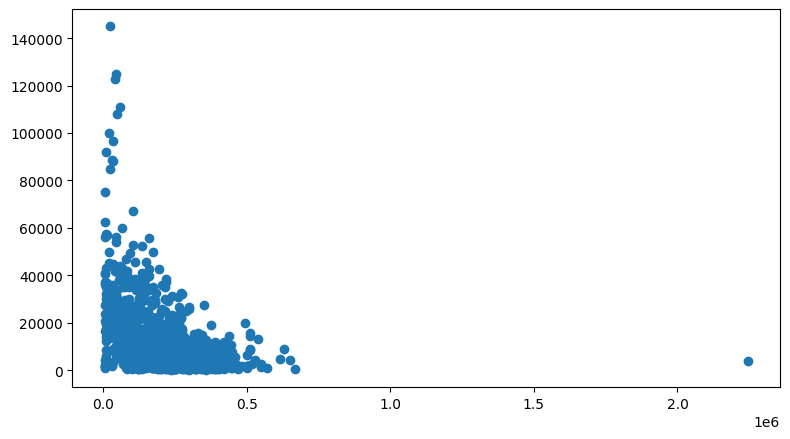

In [23]:
fig, axis = plt.subplots(figsize=(8,4.5))
#plotting code:

axis.scatter(df_ap['R5000'], df_ap['Kaina'])
#axis.legend(loc='best')
#axis.ticklabel_format(style='plain')
fig.tight_layout()
plt.show() 

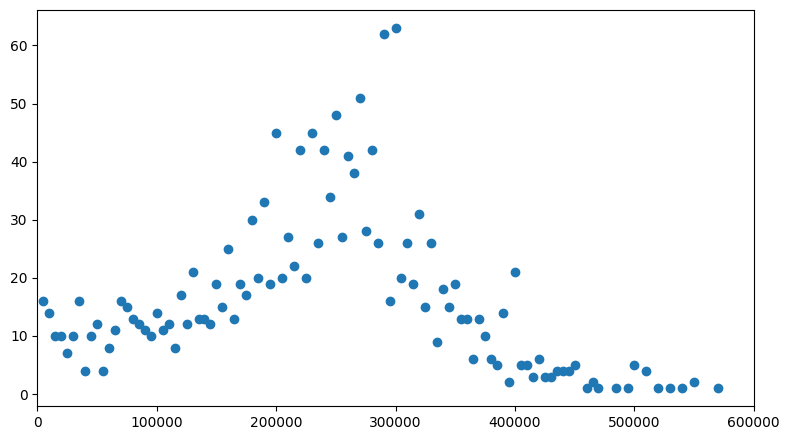

In [37]:
# groupby(), agregacijos (mean,median), reset_index() sukuria nauja indeksu stulpeli ir indeksai tampa stulpeliu
# head() su groupby()

dfg = df_ap[['R5000', 'Kaina']].groupby('R5000').count().reset_index()
dfg.head()

fig, axis = plt.subplots(figsize=(8,4.5))
#plotting code:

axis.scatter(dfg['R5000'], dfg['Kaina'])
axis.set_xlim(0, 6e5)
#axis.legend(loc='best')
#axis.ticklabel_format(style='plain')
fig.tight_layout()
plt.show()

In [48]:
dfg = df_ap[['R5000', 'Kaina']].groupby('R5000').mean(numeric_only=True).reset_index()
dfg.head()

,R5000,Kaina
0,5000.0,27957.187500
1,10000.0,30702.857143
2,15000.0,23330.800000
3,20000.0,35309.000000
4,25000.0,51850.000000


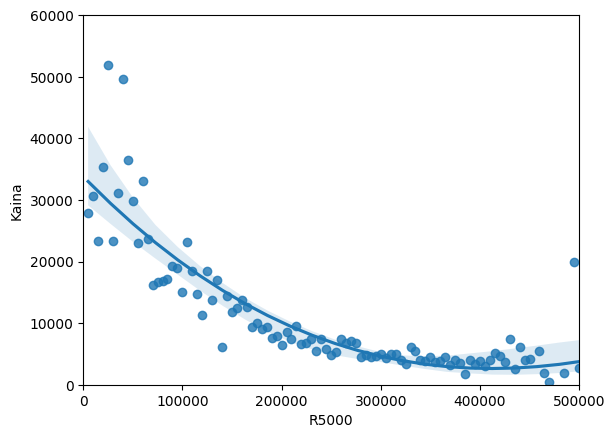

In [68]:
# seaborn regplot()


axis = sns.regplot(data=dfg, x='R5000', y='Kaina', order=3)
axis.set_xlim(0, 5e5)
axis.set_ylim(0, 6e4)
plt.show()

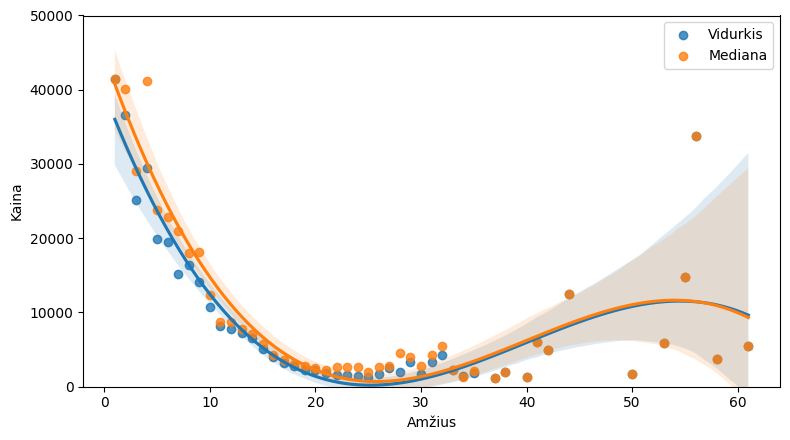

In [67]:
# Vizualizuokite, kaip nuo amžiaus priklauso automobilių kaina. Panaudokite seaborn regplot, kad pademonstruotumėte trendą - tendenciją
dfa = df_ap[['Amžius', 'Kaina']].groupby('Amžius').mean(numeric_only=True).reset_index()
dfb = df_ap[['Amžius', 'Kaina']].groupby('Amžius').median(numeric_only=True).reset_index()
fig, axis = plt.subplots(figsize=(8,4.5))
#plotting code:


#axis.legend(loc='best')
#axis.ticklabel_format(style='plain')

axis = sns.regplot(data=dfb, x='Amžius', y='Kaina', order=3, ax=axis, label='Vidurkis')
axis = sns.regplot(data=dfa, x='Amžius', y='Kaina', order=3, ax=axis, label= 'Mediana')
axis.legend(loc='best')
# axis.set_xlim(0, 5e5)
axis.set_ylim(0, 50000)
fig.tight_layout()
plt.show()

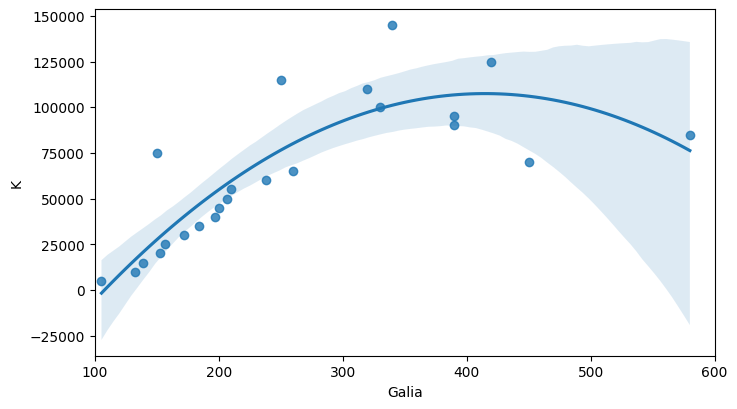

In [172]:
dfv = df_ap[['Variklis', 'Kaina']]
def gal(k):
    try:
        x =  np.ceil(float(k.replace(')','').split('(')[-1].replace('kW',''))/10)*10
        return x
    except ValueError:
        return np.nan     
dfv['Galia'] = dfv['Variklis'].apply(gal)
dfv['K'] = dfv['Kaina'].apply(lambda x: np.ceil(x/5000)*5000)
dfv_n = dfv[['Galia', 'K']].groupby('K').mean(numeric_only=True).reset_index()
fig, axis = plt.subplots(figsize=(8,4.5))
axis = sns.regplot(data=dfv_n, x='Galia', y='K', order = 2)
axis.set_xlim(1e2, 6e2)
plt.show()

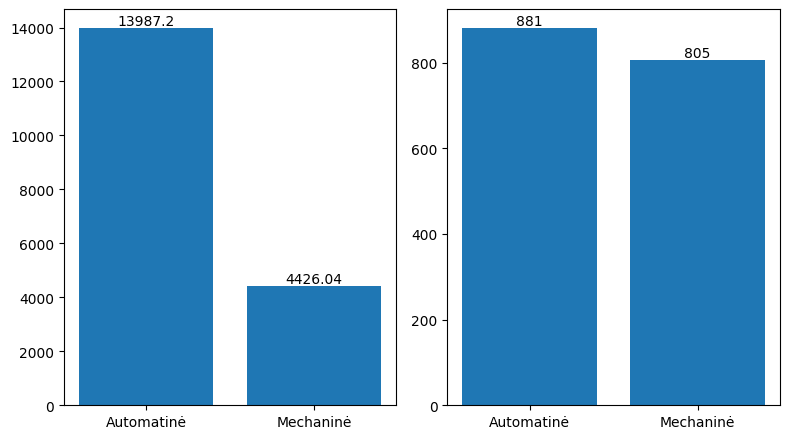

In [183]:
# kas brangiau - mechaninė ar automatinė? Kiek vienetų rinkoje buvo su mechan, ir su automat?
dfgr = df_ap[['Pavaros', 'Kaina']]
dfgr_n = dfgr[['Pavaros', 'Kaina']].groupby('Pavaros').mean(numeric_only=True).reset_index()
dfgr_c = dfgr[['Pavaros', 'Kaina']].groupby('Pavaros').count().reset_index()

fig, axes = plt.subplots(1,2,figsize=(8,4.5))
#plotting code:
x = axes[0].bar(dfgr_n['Pavaros'], dfgr_n['Kaina'])
axes[0].bar_label(x)
y = axes[1].bar(dfgr_c['Pavaros'], dfgr_c['Kaina'])
axes[1].bar_label(y)
fig.tight_layout()
plt.show()

In [ ]:
# parašykite funkciją,kuriai galėtumėte nurodyti savo norimus duomenis kaip list arba array
#  ir ji nubraižytų pie-of-pie tipo grafiką.
#  funkcijos pavadinimas PieOfPie(), argumentus, jų tipus parenkate patys

# https://matplotlib.org/stable/gallery/pie_and_polar_charts/bar_of_pie.html
# ir 
# https://stackoverflow.com/questions/59089531/generating-compound-pie-or-pie-of-pie-charts

# parašykite funkciją,kuriai galėtumėte nurodyti savo norimus duomenis kaip list arba array
#  ir ji nubraižytų bar-of-pie tipo grafiką.
#  funkcijos pavadinimas BarOfPie(), argumentus, jų tipus parenkate patys

# https://matplotlib.org/stable/gallery/pie_and_polar_charts/bar_of_pie.html

# BarOfPie(pie=[], bar=[], bar_labels=[], pie_labels=[])

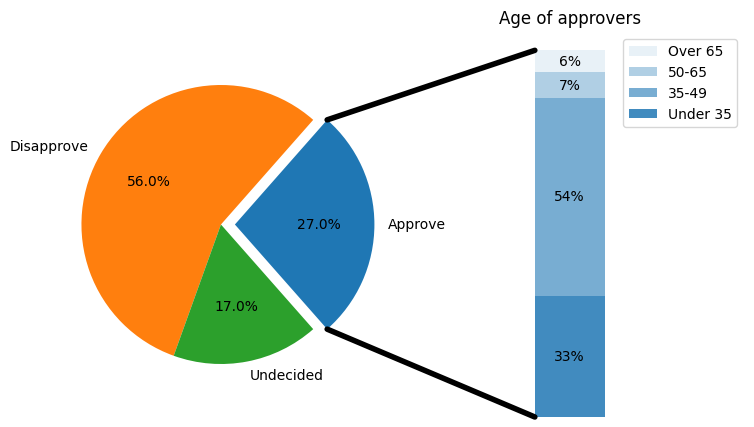

In [74]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import ConnectionPatch

# make figure and assign axis objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
fig.subplots_adjust(wspace=0)

# pie chart parameters
overall_ratios = [.27, .56, .17]
labels = ['Approve', 'Disapprove', 'Undecided']
explode = [0.1, 0, 0]
# rotate so that first wedge is split by the x-axis
angle = -180 * overall_ratios[0]
wedges, *_ = ax1.pie(overall_ratios, autopct='%1.1f%%', startangle=angle,
                     labels=labels, explode=explode)

# bar chart parameters
age_ratios = [.33, .54, .07, .06]
age_labels = ['Under 35', '35-49', '50-65', 'Over 65']
bottom = 1
width = .2

# Adding from the top matches the legend.
for j, (height, label) in enumerate(reversed([*zip(age_ratios, age_labels)])):
    bottom -= height
    bc = ax2.bar(0, height, width, bottom=bottom, color='C0', label=label,
                 alpha=0.1 + 0.25 * j)
    ax2.bar_label(bc, labels=[f"{height:.0%}"], label_type='center')

ax2.set_title('Age of approvers')
ax2.legend()
ax2.axis('off')
ax2.set_xlim(- 2.5 * width, 2.5 * width)

# use ConnectionPatch to draw lines between the two plots
theta1, theta2 = wedges[0].theta1, wedges[0].theta2
center, r = wedges[0].center, wedges[0].r
bar_height = sum(age_ratios)

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
con.set_linewidth(4)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(4)

plt.show()

In [32]:
df_ap.head()

,Gamintojas,Data,Kaina,Rida,Pavaros,Variklis,R5000,Amžius
0,Mitsubishi,1996,1450.0,173810.0,Mechaninė,2500 cm³,175000.0,28
1,Isuzu,2003,850.0,186684.0,Mechaninė,3000 cm³,190000.0,21
2,Hyundai,2004,1450.0,159326.0,Mechaninė,2400 cm³,160000.0,20
3,Toyota,2008,1450.0,249449.0,Mechaninė,2200 cm³,250000.0,16
4,Mercedes-Benz,2003,1450.0,205997.0,Automatinė,2700 cm³,210000.0,21


In [64]:
gam = df_ap['Gamintojas'].tolist()
amz = df_ap['Amžius'].tolist()
kaina = df_ap['Kaina'].tolist()

gam_n = df_ap[['Gamintojas', 'Kaina']].groupby('Gamintojas').mean(numeric_only=True).reset_index()
gam_s = df_ap[df_ap['Gamintojas'] == 'Audi'].groupby('Amžius').count().reset_index()

gamintojai = gam_n['Gamintojas'].tolist()
kainos = gam_n['Kaina'].tolist()

amziai = gam_s['Amžius'].tolist()
kiekiai = gam_s['Gamintojas'].tolist()

gam_n.head()


,Gamintojas,Kaina
0,Alfa Romeo,3500.000000
1,Aston Martin,125000.000000
2,Audi,9343.690323
3,BMW,11620.533333
4,Cadillac,9175.000000


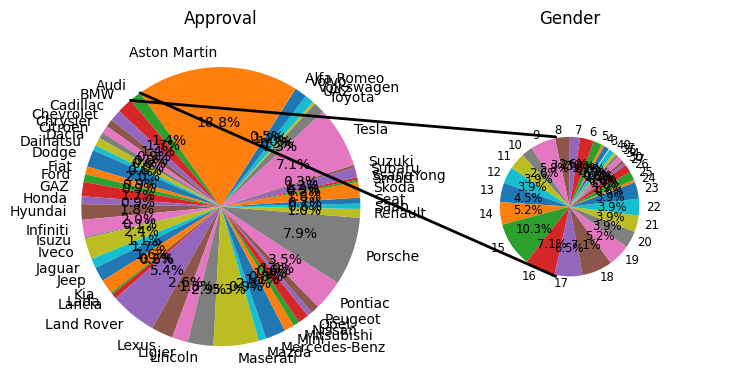

In [72]:
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import numpy as np

# make figure and assign axis objects
fig = plt.figure(figsize=(9, 5.0625))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
fig.subplots_adjust(wspace=0)



# large pie chart parameters
# ratios = [.27, .56, .17,1]
# labels = ['Approve', 'Disapprove', 'Undecided','KT']
ratios = kainos
labels = gamintojai
# explode = [0, 0, 0.1,0]
# rotate so that first wedge is split by the x-axis
angle = -180 * ratios[2]
ax1.pie(ratios, autopct='%1.1f%%', startangle=angle,
        labels=labels)

# small pie chart parameters
# ratios = [.20, .20, .60,2]
# labels = ['Male', 'Female', 'Undecided','s']
ratios = kiekiai
labels = amziai
width = .2

ax2.pie(ratios, autopct='%1.1f%%', startangle=angle,
        labels=labels, radius=0.5, textprops={'size': 'smaller'})

ax1.set_title('Approval')
ax2.set_title('Gender')

# use ConnectionPatch to draw lines between the two plots
# get the wedge data
theta1, theta2 = ax1.patches[2].theta1, ax1.patches[2].theta2
center, r = ax1.patches[2].center, ax1.patches[2].r

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(- width / 2, .5), xyB=(x, y),
                      coordsA="data", coordsB="data", axesA=ax2, axesB=ax1)
con.set_color([0, 0, 0])
con.set_linewidth(2)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(- width / 2, -.5), xyB=(x, y), coordsA="data",
                      coordsB="data", axesA=ax2, axesB=ax1)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(2)

plt.show()